In [77]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [78]:
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
tpdata = pd.read_table("%40CL_Daily.txt",delimiter=',',header=0,parse_dates=[['Date','Time']],usecols=['Date','Time','Close'])
print(tpdata['Close'][:10])

0    104.22
1    104.67
2    104.02
3    104.12
4    104.53
5    104.30
6    105.23
7    103.96
8    103.71
9    102.83
Name: Close, dtype: float64


In [79]:
from scipy.signal import savgol_filter as smooth
# this function returns the local maxima and the minima
# ltp is a list of [date, price]
# n is the width of window to examine max and min
# n has to be an odd number greater than 3
# return: max and min [(date,price),(date,price),(),(),...]
def max_min(ltp,n):
    ltp_sm = smooth(ltp['Close'],n,3)
    max_points = []
    min_points = []
    ltp_dif = np.zeros(ltp_sm.shape[0]-1)
    ltp_dif = ltp_sm[1:]-ltp_sm[:-1]
    center = int((n-1)/2)
    for i in range(ltp_dif.shape[0]-n+2):
        window = ltp_dif[i:i+n-1]
        front = window[:center]
        back = window[center:]
        s_first = np.sum(front<0)
        s_back = np.sum(back>0)
        r_first = np.sum(front>0)
        r_back = np.sum(back<0)
        if(r_first == center and r_back == center):
            max_points.append((ltp['Date_Time'][i+center],ltp['Close'][i+center]))
            # print(ltp[i+center])
        if(s_first== center and s_back== center):
            min_points.append((ltp['Date_Time'][i+center],ltp['Close'][i+center]))
            # print(ltp[i+center])
    return max_points,min_points
scanning_window=5

In [80]:
# sort the max and min according to the price.
# this facilitate clustering in next step
maxima,minima = max_min(tpdata[:500],scanning_window)
max_points = sorted(maxima, key=lambda x: x[1])
min_points = sorted(minima, key=lambda x: x[1])
# max_pair = maxima[maxima[:,1].argsort()]
# min_pair = minima[minima[:,1].argsort()]
print(max_points)
print(min_points)

[(Timestamp('2002-01-28 17:00:00'), 95.519999999999996), (Timestamp('2002-02-04 17:00:00'), 95.609999999999999), (Timestamp('2001-11-21 17:00:00'), 95.659999999999997), (Timestamp('2001-12-19 17:00:00'), 95.689999999999998), (Timestamp('2001-12-27 17:00:00'), 96.450000000000003), (Timestamp('2001-12-05 17:00:00'), 96.560000000000002), (Timestamp('2002-02-15 17:00:00'), 96.819999999999993), (Timestamp('2002-01-07 17:00:00'), 97.340000000000003), (Timestamp('2001-11-12 17:00:00'), 98.280000000000001), (Timestamp('2001-10-10 17:00:00'), 99.659999999999997), (Timestamp('2002-03-20 17:00:00'), 99.909999999999997), (Timestamp('2001-10-01 17:00:00'), 100.14), (Timestamp('2002-06-03 17:00:00'), 101.11), (Timestamp('2002-04-19 17:00:00'), 101.41), (Timestamp('2002-06-17 17:00:00'), 102.11), (Timestamp('2002-04-30 17:00:00'), 102.34999999999999), (Timestamp('2002-06-28 17:00:00'), 102.43000000000001), (Timestamp('2002-04-03 17:00:00'), 102.59), (Timestamp('2002-07-18 17:00:00'), 103.319999999999

In [106]:
# this function take in sorted date-price tupel and find the cluster
# according to price and threshold given
# it return a group in shape [[(date,price),(date,price),()...],[],...]
def cluster(pairs, threshold):
    groups = []
    current = []
    vl = 0
    for pair in pairs:
        # print(pair)
        if not current:
            current.append(pair)
            vl = pair[1]
            #print('1')
        elif pair[1]-vl<threshold:
            current.append(pair)
            #print('2')
        else:
            if len(current)>1:
                groups.append(sorted(current))
            vl = pair[1]
            current = [pair]
            #print('3')
    return groups
cluster_threshold = 0.8

In [107]:
# max_points clustted together is called max_group
max_group = cluster(max_points,cluster_threshold)
min_group = cluster(min_points,cluster_threshold)
print(len(min_group))
print()
print(max_group)

15

[[(Timestamp('2001-11-21 17:00:00'), 95.659999999999997), (Timestamp('2001-12-19 17:00:00'), 95.689999999999998), (Timestamp('2002-01-28 17:00:00'), 95.519999999999996), (Timestamp('2002-02-04 17:00:00'), 95.609999999999999)], [(Timestamp('2001-12-05 17:00:00'), 96.560000000000002), (Timestamp('2001-12-27 17:00:00'), 96.450000000000003), (Timestamp('2002-02-15 17:00:00'), 96.819999999999993)], [(Timestamp('2001-10-01 17:00:00'), 100.14), (Timestamp('2001-10-10 17:00:00'), 99.659999999999997), (Timestamp('2002-03-20 17:00:00'), 99.909999999999997)], [(Timestamp('2002-04-19 17:00:00'), 101.41), (Timestamp('2002-06-03 17:00:00'), 101.11)], [(Timestamp('2002-04-03 17:00:00'), 102.59), (Timestamp('2002-04-30 17:00:00'), 102.34999999999999), (Timestamp('2002-06-17 17:00:00'), 102.11), (Timestamp('2002-06-28 17:00:00'), 102.43000000000001)], [(Timestamp('2002-07-18 17:00:00'), 103.31999999999999), (Timestamp('2002-10-30 17:00:00'), 103.47), (Timestamp('2002-11-22 17:00:00'), 104.06)], [(T

transfer back to numpy array for easiness to index
they are tuple in prior steps because np array only support
one dtype. String and float can not co-exist. For sorting and
clustering purposes, they have to be converted to tuple

In [108]:
# assumes each group in group list is sorted already
# data is the total data [date,price]. Date should be in datetime64[D]
# the output is of shape [[[date],[price]],[[date],[price]],...]
def into_arr(group_list,data,threshold,support=True):
    groups=[]
    for group in group_list:
        # extract date, price
        date = np.asarray(group)[:,0]
        price = np.asarray(group)[:,1]
        price = price.astype(np.float)
        # form line, calculate when line start and stop
        average_price = np.average(price)
        mask_inside_range = np.bitwise_and(data[:,0] > date[0],data[:,0]<date[-1])
        mask_after = data[:,0]>date[-1]
        # the [1] is for removing the automatic index
        last_date = data[:,0][-1]
        if support:
            break_through = data[:,1] < np.min(price)
        else:
            break_through = data[:,1] > np.max(price)
        #eliminate the chance the resistance is fake.
        if np.sum(np.bitwise_and(mask_inside_range,break_through))>1:
            continue
        break_through = np.bitwise_and(mask_after,break_through)
        if np.sum(break_through) > 0:
            # the support stops somewhere
            last_date = data[:,0][np.argwhere(break_through)[0][0]]
#         print("the current group is ")
#         print(group)
#         print(last_date, end=" ")
#         if(len(np.argwhere(break_through))>0):
#             print(data[:,1][np.argwhere(break_through)[0][0]])
#         else:
#             print(data[:,1][-1])
#         print('average price', end=' ')
#         print(average_price)
        date_range = pd.date_range(date[0],last_date)
        df = pd.DataFrame({'support':[average_price for i in range(date_range.shape[0])]},index=date_range)
        if(not support):
            df.rename(columns={'support':'resistance'}, inplace=True)
        groups.append(df)
    return groups

In [109]:
# support = into_arr(min_group,tpdata[:500].as_matrix(),threshold,True)
# print("###################################################################")
resistance = into_arr(max_group,tpdata[:500].as_matrix(),threshold,False)

the current group is 
[(Timestamp('2001-11-21 17:00:00'), 95.659999999999997), (Timestamp('2001-12-19 17:00:00'), 95.689999999999998), (Timestamp('2002-01-28 17:00:00'), 95.519999999999996), (Timestamp('2002-02-04 17:00:00'), 95.609999999999999)]
2002-02-12 17:00:00 96.49
average price 95.62
the current group is 
[(Timestamp('2001-12-05 17:00:00'), 96.560000000000002), (Timestamp('2001-12-27 17:00:00'), 96.450000000000003), (Timestamp('2002-02-15 17:00:00'), 96.819999999999993)]
2002-03-01 17:00:00 97.48
average price 96.61
the current group is 
[(Timestamp('2001-10-01 17:00:00'), 100.14), (Timestamp('2001-10-10 17:00:00'), 99.659999999999997), (Timestamp('2002-03-20 17:00:00'), 99.909999999999997)]
2002-03-27 17:00:00 100.63
average price 99.9033333333
the current group is 
[(Timestamp('2002-04-19 17:00:00'), 101.41), (Timestamp('2002-06-03 17:00:00'), 101.11)]
2002-06-14 17:00:00 101.8
average price 101.26
the current group is 
[(Timestamp('2002-04-03 17:00:00'), 102.59), (Timestamp(

In [110]:
len(resistance)

12

In [111]:
def plot_sr(data,support,resist):
    color=['b']
    for i in support:
        data = data.merge(i,how='left',left_on='Date_Time',right_index=True)
        color.append('g')
    for i in resist:
        data = data.merge(i,how='left',left_on='Date_Time',right_index=True)
        color.append('r')
    data.plot(x='Date_Time',legend=False,color = color)
    #print(data[:5])
    plt.show()

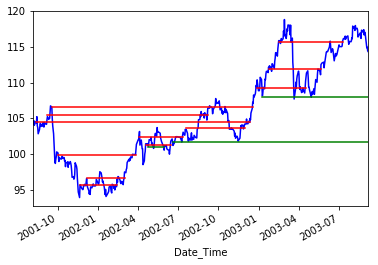

In [112]:
plot_sr(tpdata[:500],support,resistance)